<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/4_mlflow_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Práctico 2
## Implementación de una red neuronal RNN

### Experimentos sobre muestras

## Registro de experimentos con MLflow

A la hora de trabajar con problemas de aprendizaje supervisado en general, y de aprendizaje profundo en particular, es necesario llevar un buen registro de los experimentos realizados. En particular, cuando se hace uso de algún tipo de optimización de hiperparámetros (ya sea búsqueda exhaustiva, búsqueda aleatoria o algo más complejo como optimización bayesiana), es crucial tener registro de que se fue haciendo para tomar las decisiones.

[MLflow](https://mlflow.org/) es una plataforma de código abierto que facilita mucho lleva y cuenta de los experimentos que se están realizando. Se pueden ejecutar experimentos y guardar hiperparámetros y métricas de los mismos.

A continuación vamos a ver un ejemplo muy sencillo de como realizar un experimento utilizando MLflow y el conjunto de datos de IMDB.

Gente! Dato importante que faltó en el repo (en breve lo voy a subir)
Para los que trabajen con word embeddings, fijense que los de Glove no les van a servir, porque el MeliChallenge está en español y los embeddings en Ingles. Para esto hay dos opciones igual de válidas:

Descargar embeddings en español
Entrenar sus propios embeddings

Para la opción 1:
Descarguen el los txt de los SBW (los txt).
import bz2
with bz2.open(pretrained_embeddings_path, "rt") as fh: en su modelo, donde está lo de abrir el GZIP
`model = MyClassifier(embs_path="./data/SBW-vectors-300-min5.txt.bz2", emb_size=300)` cuando instancien los modelos. Los embeddings tienen 300 dims.

Para la opción 2:
self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx)
Con vocab_size el tamaño del vocabulario del corpus del MeliChallenge, emb_size un tamaño de embedding (pueden usar 50, directamente si no quieren ajustar esto) y padding_idx=0.

In [1]:
#CORRER UNA VEZ
# !mkdir ./data
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# !curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
# !tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
# !pip install mlflow
#!curl -L https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -o ./SBW-vectors-300-min5.txt.bz2

### Librerías

In [2]:
import csv
import gzip
import bz2
import mlflow
import numpy as np
import pandas as pd
import tempfile
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from gensim import corpora
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange

import json
import matplotlib.pyplot as plt
import seaborn as sns
import functools
tqdm.pandas()


In [3]:
# Ensure version 4.X
import gensim
gensim.__version__

'4.2.0'

## Dataset

Nos basaremos en el dataset que creamos para el [notebook 2](https://github.com/DiploDatos/AprendizajeProfundo/blob/master/3_datasets.ipynb), con la diferencia de que pasaremos el dataframe de manera directa (esto es para poder hacer split en train/test).

Recordemos de la [notebook 2](https://github.com/DiploDatos/AprendizajeProfundo/blob/master/3_datasets.ipynb) que la clase abstracta `torch.utils.data.Dataset `es la [clase base](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataset) para construir un dataset de `PyTorch`. Cualquier dataset personalizado debe heredar de dicha clase e implementar los siguientes métodos:

`__len__`: Para que el comando `len(dataset)` devuelva el tamaño del conjunto de datos.

`__getitem__`: Para soportar indexado de manera que `dataset[i]` devuelva el elemento `i`.

In [4]:
class MeliChallenge(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

## Lectura de datos

In [5]:
columns_interesting = ['title','category']

## Train

In [6]:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
train_df = train_df[columns_interesting]
train_df.head()

,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES


In [7]:
len(train_df)

4895280

## Validation

In [8]:
validation_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
validation_df = validation_df[columns_interesting]
validation_df.head()

,title,category
0,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS
1,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS
2,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS
3,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES
4,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS


In [9]:
len(validation_df)

1223820

## Test

In [10]:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.test.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
test_df = test_df[columns_interesting]
test_df.head()

,title,category
0,Mochilas Maternales Bolsos Bebe Simil Cuero Ma...,DIAPER_BAGS
1,Bolso Maternal/bebe Incluye Cambiador + Correa...,DIAPER_BAGS
2,Mochila Maternal Land + Gancho Envio Gratis-cc,DIAPER_BAGS
3,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS
4,Bolso Maternal Moderno Con Cambiador Y Correa ...,DIAPER_BAGS


In [11]:
len(test_df)

63680

## Exploración de Dataset

In [12]:
cat=train_df['category'].head(5)
cat

0                DOLLHOUSES
1             TOILETRY_BAGS
2           CAR_SEAT_COVERS
3    AUTOMOTIVE_CLUTCH_KITS
4          CAMERA_BATTERIES
Name: category, dtype: object

In [13]:
cat_top_train = train_df['category'].value_counts()[:15]
cat_top_val = validation_df['category'].value_counts()[:15]
cat_top_test = test_df['category'].value_counts()[:15]

Text(0.5, 1.0, 'Test set')

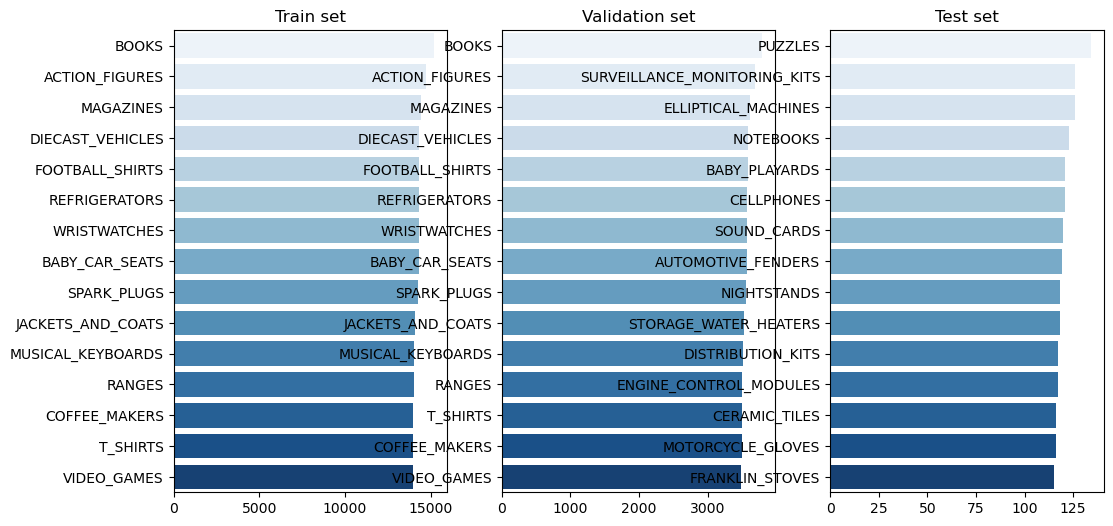

In [14]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

sns.barplot(y=cat_top_train.index, x=cat_top_train.values, ax=ax[0], palette="Blues")
ax[0].set_title('Train set')

sns.barplot(y=cat_top_val.index, x=cat_top_val.values, ax=ax[1], palette="Blues")
ax[1].set_title('Validation set')

sns.barplot(y=cat_top_test.index, x=cat_top_test.values, ax=ax[2], palette="Blues")
ax[2].set_title('Test set')

In [15]:
# Generación de muestras

train_dataset = train_df.sample(frac=0.1, random_state=1, ignore_index=True)
validation_dataset = validation_df.sample(frac=0.1, random_state=1, ignore_index=True)
test_dataset = test_df.copy()

In [16]:
train, validation, test = len(train_dataset), len(validation_dataset), len(test_df)
print(f'Train: {train} - Validation: {validation} - Test: {test}')

Train: 489528 - Validation: 122382 - Test: 63680


In [17]:
# Contamos las categorias en el Dataset completo
print(f'Train unique categories: {train_df.category.nunique()}\n\
Validation unique categories: {validation_df.category.nunique()}\n\
Test unique categories: {test_df.category.nunique()}')

Train unique categories: 632
Validation unique categories: 632
Test unique categories: 632


In [18]:
# Contamos las categorias en despues de tomar las muestras en train y validation
print(f'Train unique categories: {train_dataset.category.nunique()}\n\
Validation unique categories: {validation_dataset.category.nunique()}\n\
Test unique categories: {test_dataset.category.nunique()}')

Train unique categories: 632
Validation unique categories: 632
Test unique categories: 632


## Preprocess


En este caso vamos a utilizar un sólo módulo para transformar los datos de IMDB. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings y así permitir mayor manipulación de los embeddings (en lugar de utilizar embeddings fijos).

Vamos a estar trabajando con la librería [gensim](https://pypi.org/project/gensim/) previamente importada para el procesamiento del lenguaje natural (pueden ver su código open source en este [link](https://github.com/RaRe-Technologies/gensim) ).

In [19]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
        
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [20]:
full_df_muestra=train_dataset.copy()
full_df_muestra=full_df_muestra.append(validation_dataset, ignore_index=True)
full_df_muestra=full_df_muestra.append(test_dataset, ignore_index=True)
full_df_muestra.shape


/tmp/ipykernel_4161254/242076517.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_muestra=full_df_muestra.append(validation_dataset, ignore_index=True)
/tmp/ipykernel_4161254/242076517.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_muestra=full_df_muestra.append(test_dataset, ignore_index=True)


(675590, 2)

In [21]:

preprocess_full = RawDataProcessor(full_df_muestra)


In [22]:
print(f'Tamaño del diccionario: {len(preprocess_full.dictionary)}')

Tamaño del diccionario: 50002


In [23]:
train_dataset = MeliChallenge(train_dataset, transform=preprocess_full)
validation_dataset = MeliChallenge(validation_dataset, transform=preprocess_full)
test_dataset = MeliChallenge(test_dataset, transform=preprocess_full)

# Collation Function - Data Loader



Como en este caso trabajamos con secuencias de palabras (representadas por sus índices en un vocabulario), cuando queremos buscar un *batch* de datos, el `DataLoader` de PyTorch espera que los datos del *batch* tengan la misma dimensión (para poder llevarlos todos a un tensor de dimensión fija). Esto lo podemos lograr mediante el parámetro de `collate_fn`. En particular, esta función se encarga de tomar varios elementos de un `Dataset` y combinarlos de manera que puedan ser devueltos como un tensor de PyTorch. Muchas veces la `collate_fn` que viene por defecto en `DataLoader` sirve (como se vio en el notebook 2), pero este no es el caso. Se define un módulo `PadSequences` que toma un valor mínimo, opcionalmente un valor máximo y un valor de relleno (*pad*) y dada una lista de secuencias, devuelve un tensor con *padding* sobre dichas secuencias.

In [24]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

## DataLoaders

Ya habiendo definido nuestros conjuntos de datos y nuestra `collation_fn`, podemos definir nuestros `DataLoader`, uno para entrenamiento y otro para evaluación. Ver que la diferencia fundamental está en `shuffle`, no queremos mezclar los valores de evaluación cada vez que evaluamos porque al evaluar mediante *mini-batchs* nos puede generar inconsistencias.

In [25]:
pad_sequences = PadSequences()
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False,
                               collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

In [26]:
print(iter(train_loader).__next__()['data'].shape)
print(iter(validation_loader).__next__()['data'].shape)
print(iter(test_loader).__next__()['data'].shape)

torch.Size([128, 10])
torch.Size([128, 12])
torch.Size([128, 9])


In [27]:
print(iter(train_loader).__next__()['data'].shape)

torch.Size([128, 10])


## El modelo de clasificación

Para clasificación utilizaremos un perceptrón multicapa de dos capas ocultas. Claramente este modelo es naive y prácticamente todo lo que está *hardcodeado* (e.g. los tamaños de las capas o la cantidad de capas) podría ser parte de los parámetros del modelo. En particular, tenemos la capa de `Embeddings` que es rellenada con los valores de embeddings preentrenados (los de Glove en este caso).

# Entrenamiento de la RED - Experimento 1

Categoría de la red neuronal recurrente
Para el caso propuesto la red debe tener una arquitectura many-to-one con entrada dada por la secuencia máxima de palabras en nuestro dataset y salida dada por el número de categorías que esperamos clasificar.

In [28]:
# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

In [29]:
class ImdbLSTM(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 hidden_layer,
                 num_layers,
                 dropout,
                 bidirectional,
                 freeze_embedings):
        super().__init__()           
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)  
        
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
       
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parameters
        self.lstm = nn.LSTM(vector_size, hidden_layer, batch_first=True)
        
        #fully connected layer parameters
        self.linear1 = nn.Linear(hidden_layer, 632)
    
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        out = self.linear1(ht[-1])
        return out

In [55]:
model = ImdbLSTM(
    "./SBW-vectors-300-min5.txt.bz2", 
    dictionary=preprocess_full.dictionary,
    vector_size=300,
    hidden_layer=64,
    num_layers=1,
    dropout=0.1,
    bidirectional=True,
    freeze_embedings=True,
)
print(model)

ImdbLSTM(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=632, bias=True)
)


In [56]:
example_batch = iter(train_loader).__next__()
preds = model(example_batch['data']) # Predictions for an entire batch
preds = [x[0] for x in preds.tolist()]
len(preds)

128

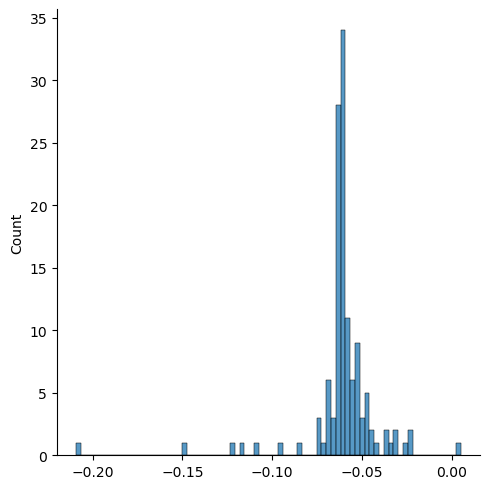

In [57]:
sns.displot(preds)

In [34]:
BATCHES_t = (int(len(train_dataset)/batch_size) + int(len(train_dataset) % batch_size>0))
BATCHES_v = (int(len(validation_dataset)/batch_size) + int(len(validation_dataset) % batch_size>0))

## Experimento de MLflow

Por último, ya tenemos todos los bloques para construir nuestro experimento de MLflow. Anotamos los parámetros del modelo y lanzamos a correr nuestro experimento. Cada vez que finaliza un epoch guardamos algunas métricas. Al finalizar todos los epochs corremos algunas métricas extras de evaluación.

In [61]:
#Mandamos modelo a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Hiperparametros
learning_rate = 0.005
weight_decay = 0.00001
EPOCHS = 5
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


mlflow.set_experiment("Meli_RNN_Muestras_1")

with mlflow.start_run():
    mlflow.log_param("model_name", "RNN_Muestras_8")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_layer": 64,
        "num_layers": 1,
        "Epochs": EPOCHS,
        "Dropout": 0.1,
        "optimizer": optimizer,
        "Learning Rate": learning_rate,
        "weight_decay":weight_decay,
        "Bidireccional":True
    })


    
    for epoch in trange(EPOCHS):
        model.to(device)
        model.train()
        running_loss = 0.0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(train_loader, total=BATCHES_t)
            
        #Train
        print("Epoch", epoch)
        for idx, batch in enumerate(pbar):
            data = batch["data"].to(device)
            target = batch["target"].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss_function(output, target)
            loss_value.backward()
            optimizer.step()
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
            running_loss += loss_value.item()
            running_loss_flow.append(loss_value.item())
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
        metric = balanced_accuracy_score(targets, predictions)
        mlflow.log_metric("train_balanced_acc", metric, epoch + 1)
        
        model.eval()
        running_loss = 0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(validation_loader, total=BATCHES_v)
        
        # Validation
        with torch.no_grad():
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                pred = torch.max(output, 1)[1]
                loss_value = loss_function(output, target)
                targets.extend(target.cpu().numpy())
                predictions.extend(pred.cpu().numpy())
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
            metric = balanced_accuracy_score(targets, predictions)
            mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

        print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.7293452218636092


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7473395647773271


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7589683137958387


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.7686140163519022


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.7688518178002908


In [33]:
# mlflow.tracking.MlflowClient().list_experiments()
# mlflow.search_runs()

# Entrenamiento de la RED - Experimento 2

## Arquitectura de la Red Neuronal - Experimento 2


In [52]:
class RNNMeLiChallenge(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings,
                 hidden_layer,
                 p_dropout,
                 bidirectional,
                 activation_fn):
        super().__init__()
        # Inicializamos la matriz de embeddings
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        
        #Trabajamos con los embeddings preentrenados
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
                    
        # Los guardamos en la variable embeddings
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        #LSTM parametros
        self.lstm = nn.LSTM(vector_size, hidden_layer, batch_first=True, bidirectional=bidirectional)
        
        #Parametros de las capas
        self.linear1 = nn.Linear(hidden_layer, hidden_layer)
        self.linear1_dp = nn.Dropout(p=p_dropout)
        self.output_layer = nn.Linear(hidden_layer, 632)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        x = self.embeddings(x)
        lstm_out, (ht, ct) = self.lstm(x)
        x = self.activation_fn(self.linear1(ht[-1]))
        if self.training:
            x = self.linear1_dp(x)
        out = self.output_layer(x)
        return out

In [85]:
model = RNNMeLiChallenge(pretrained_embeddings_path='./SBW-vectors-300-min5.txt.bz2',
                        dictionary=preprocess_full.dictionary,
                        vector_size=300,
                        freeze_embedings=True,
                        hidden_layer=254,
                        bidirectional=True,
                        p_dropout=0.1,
                        activation_fn=F.gelu)
print(model)

RNNMeLiChallenge(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (lstm): LSTM(300, 254, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=254, out_features=254, bias=True)
  (linear1_dp): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=254, out_features=632, bias=True)
)


In [86]:
#Mandamos modelo a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Hiperparametros

hidden_layer = 254
bidirectional = True
p_dropouts = 0.1
activation_fns = F.gelu
lr = 0.001
wd = 0.00001
EPOCHS = 5
loss_function = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)


mlflow.set_experiment("Meli_RNN_Muestras_2")

with mlflow.start_run():
    mlflow.log_param("model_name", "RNN_Muestras_16")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 300,
        "hidden_layer":256,
        "num_layers": 2,
        "Epochs": EPOCHS,
        "Dropout": p_dropouts,
        "optimizer": optimizer,
        "Learning Rate": lr,
        "weight_decay":wd,
        "Bidireccional":True,
        "activation_fns": activation_fns
    })


    
    for epoch in trange(EPOCHS):
        model.to(device)
        model.train()
        running_loss = 0.0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(train_loader, total=BATCHES_t)
            
        #Train
        print("Epoch", epoch)
        for idx, batch in enumerate(pbar):
            data = batch["data"].to(device)
            target = batch["target"].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss_function(output, target)
            loss_value.backward()
            optimizer.step()
            targets.extend(batch["target"].numpy())
            predictions.extend(torch.argmax(output.cpu(), 1).numpy())
            running_loss += loss_value.item()
            running_loss_flow.append(loss_value.item())
            if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                pbar.set_description(f"[Train {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                running_loss = 0.0
        mlflow.log_metric("train_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
        metric = balanced_accuracy_score(targets, predictions)
        mlflow.log_metric("train_balanced_acc", metric, epoch + 1)
        
        model.eval()
        running_loss = 0
        running_loss_flow = []
        targets = []
        predictions = []
        pbar = tqdm(validation_loader, total=BATCHES_v)
        
        # Validation
        with torch.no_grad():
            for idx, batch in enumerate(pbar):
                data = batch["data"].to(device)
                target = batch["target"].to(device)  
                output = model(data)
                pred = torch.max(output, 1)[1]
                loss_value = loss_function(output, target)
                targets.extend(target.cpu().numpy())
                predictions.extend(pred.cpu().numpy())
                running_loss += loss_value.item()
                running_loss_flow.append(loss_value.item())
                if idx > 0 and idx % 50 == 0:    # print every 50 mini-batches
                    pbar.set_description(f"[Validation {epoch + 1}, {idx}] loss: {running_loss / 50:.4g}")
                    running_loss = 0.0
            mlflow.log_metric("val_loss", sum(running_loss_flow) / len(running_loss_flow), epoch + 1)
            metric = balanced_accuracy_score(targets, predictions)
            mlflow.log_metric("val_balanced_acc", metric, epoch + 1)

        print(f'Epoch: {epoch + 1} Balanced accuracy: {metric}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 1 Balanced accuracy: 0.7345296128990368


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 2 Balanced accuracy: 0.7817797974672634


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 3 Balanced accuracy: 0.7971929917246398


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 4 Balanced accuracy: 0.8062785398392727


  0%|          | 0/3825 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/957 [00:00<?, ?it/s]

Epoch: 5 Balanced accuracy: 0.8113053721290248


In [87]:
mlflow.tracking.MlflowClient().list_experiments()
mlflow.search_runs()

/tmp/ipykernel_4161254/802100939.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  mlflow.tracking.MlflowClient().list_experiments()


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_balanced_acc,metrics.val_balanced_acc,metrics.train_loss,metrics.val_loss,...,params.freeze_embedding,params.num_layers,params.hidden_layer,params.embedding_size,params.Learning Rate,params.Epochs,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,fa9570f9702743b3a1d2e14edd2bb537,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 23:37:16.189000+00:00,2022-11-25 23:56:32.658000+00:00,0.841096,0.811305,0.637809,0.825647,...,True,2,256,300,0.001,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,upbeat-moth-364,cdagatti
1,9acdbc80d98e480f9c89ba25d5650f67,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 23:22:44.715000+00:00,2022-11-25 23:32:28.073000+00:00,0.842600,0.814289,0.639556,0.820438,...,True,2,256,300,0.001,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,powerful-goat-866,cdagatti
2,b0b6e034a137468c91e37d1e21f18e09,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 23:09:39.503000+00:00,2022-11-25 23:18:17.684000+00:00,0.842018,0.810863,0.633753,0.829276,...,True,2,256,300,0.001,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,gregarious-duck-464,cdagatti
3,fb6ad4e766b8434da730a66f41d09a2f,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 22:54:30.010000+00:00,2022-11-25 23:05:04.614000+00:00,0.873730,0.814066,0.483800,0.841161,...,True,2,256,300,0.001,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,upset-dog-707,cdagatti
4,7742e682b92c43bb8a08f1e71aaeec29,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 22:42:17.984000+00:00,2022-11-25 22:52:25.378000+00:00,0.835475,0.808445,0.656615,0.837373,...,True,2,256,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,kindly-boar-529,cdagatti
5,370dfac0ebb648aab6365de0a06c04c9,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 22:32:41.594000+00:00,2022-11-25 22:40:58.831000+00:00,0.007679,0.009450,6.277750,6.271654,...,True,2,256,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,polite-croc-920,cdagatti
6,680a70f9705d40d0a1effc6eda323360,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 22:17:42.796000+00:00,2022-11-25 22:27:07.889000+00:00,0.770043,0.774129,0.952662,0.965465,...,True,2,256,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,victorious-chimp-404,cdagatti
7,9500f5b94634404dbfd26f4e9b39344c,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 22:03:10.912000+00:00,2022-11-25 22:12:23.581000+00:00,0.795879,0.790785,0.833472,0.925080,...,True,2,256,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,tasteful-bee-335,cdagatti
8,d43fb980d2da4246b9f8f96338bbe55d,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 21:51:06.906000+00:00,2022-11-25 21:59:53.213000+00:00,0.783287,0.777469,0.894747,0.954877,...,True,2,256,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,clumsy-fowl-915,cdagatti
9,2bd0dd5c86974caabe7a16b5be6c17d3,16,FINISHED,file:///users/cdagatti/Deep_Learning_Diplo/mlr...,2022-11-25 21:40:28.545000+00:00,2022-11-25 21:48:05.705000+00:00,0.757508,0.765278,1.007169,1.007918,...,True,2,64,300,0.005,5,/users/cdagatti/miniconda3/envs/deeplearning/l...,LOCAL,serious-skunk-655,cdagatti
